In [46]:
import os 
import tensorflow 
from PIL import Image, ImageDraw
import math
import pandas as pd 
from tqdm import tqdm 
import random 
import shutil

In [47]:
folder_sources = []
Orig_Dataset_path = "Segmented Herbal Leaf images"
New_Dataset_path = "Transformed"

for file in os.listdir(Orig_Dataset_path):
    folder_sources.append(file)
        
print(folder_sources)

['Artocarpus Heterophyllus (Jackfruit)', 'Blumea Balsamifera (Sambong)', 'Citrus Limon (Lemon)', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Momordica Charantia (Ampalaya)', 'Moringa Oleifera (Malunggay)', 'Psidium Guajava (Guava)', 'Vitex Negundo (Lagundi)']


In [48]:
for folder in folder_sources:
    f_ = os.path.join(New_Dataset_path, folder)
    if not os.path.exists(f_):
        os.mkdir(f_)
        print("Created Path:", f_)

In [49]:
# Degrees is in radians
def calculate_new_coords(degrees, x, y, iw, ih):
    # qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    # qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    # res_x = iw / 2 + (x - iw / 2) * math.cos(degrees) + (y - ih / 2) * math.sin(degrees)
    # res_y = ih / 2 - (x - iw / 2) * math.sin(degrees) + (y - ih / 2) * math.cos(degrees)

    res_x = iw / 2 + (x - iw / 2) * math.cos(degrees) - (y - ih / 2) * math.sin(degrees)
    res_y = ih / 2 + (x - iw / 2) * math.sin(degrees) + (y - ih / 2) * math.cos(degrees)
    
    return (res_x, res_y)

In [52]:
BASE_IMAGE_SIZE = ((100, 100))
BASE_CANVAS_SIZE = ((200, 200))
X_VARIATIONS = 1
Y_VARIATIONS = 1
ROTATION_VARIATION = 16
ROTATION_DEGREES = 360 / ROTATION_VARIATION
DRAW_BOUNDING_BOX = False
BORDER_WIDTH = 5 
BORDER_COLOR = "Blue"

In [53]:
for folder in tqdm(folder_sources):
    current_folder_dict = {
        "image_name" : [],
        "x0" : [],
        "y0" : [],
        "x1" : [],
        "y1" : [],
        "class" : []
    }

    for image in os.listdir(os.path.join(Orig_Dataset_path, folder)):
        #print(image)

        current_image = Image.open(os.path.join(Orig_Dataset_path, folder, image))
        current_image.thumbnail(BASE_IMAGE_SIZE)
        
        x0, y0 = (0, 0)
        x1, y1 = current_image.size 
        iw, ih = current_image.size 
        
        # Rotate Image
        for i in range(ROTATION_VARIATION + 1):
            current_degrees = int(i * ROTATION_DEGREES)

            rotated_image = current_image.copy()
            rotated_image = rotated_image.rotate(current_degrees, expand=True)

            r_i_width, r_i_height = rotated_image.size

            original_bbox_coords = [(x0, y0), (x1, y0), (x1, y1), (x0, y1)]
            _degrees = math.radians(current_degrees)
            

            new_coords = [calculate_new_coords(_degrees, x, y, iw, ih) for x, y in original_bbox_coords]
            x_min, x_max = 0, iw 
            y_min, y_max = 0, ih 

            for x, y in new_coords:
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                x_max = max(x, x_max)
                y_max = max(y, y_max)

            excess_neg_x = abs(min(0, x_min))
            excess_neg_y = abs(min(0, y_min))
            
            final_bbox_coords = [(x_min, y_min), (x_max, y_max)]
            final_bbox_coords = [(x + excess_neg_x, y + excess_neg_y) for x, y in final_bbox_coords]
            #final_bbox_coords = new_coords
                
            # Transposition
            c_w , c_h = BASE_CANVAS_SIZE

            x_steps = abs(r_i_width - c_w) / X_VARIATIONS
            y_steps = abs(r_i_height - c_h) / Y_VARIATIONS
            
            for y in range(Y_VARIATIONS + 1):
                for x in range(X_VARIATIONS + 1):
                    canvas = Image.new("RGB", BASE_CANVAS_SIZE)
                    x_movement, y_movement = int(x_steps) * x, int(y_steps) * y
                    canvas.paste(rotated_image, (x_movement, y_movement))
                    

                    transposed_bbox_coords = [(x + x_movement, y + y_movement) for x, y in final_bbox_coords]
                    #print(transposed_bbox_coords)

                    if DRAW_BOUNDING_BOX:
                        _d = ImageDraw.Draw(canvas)
                        _d.rectangle(transposed_bbox_coords, width=BORDER_WIDTH, outline=BORDER_COLOR)

                    #display(canvas)

                    c0, c1 = transposed_bbox_coords
                    _x0, _y0 = c0 
                    _x1, _y1 = c1

                    
                    current_folder_dict["x0"].append(_x0 / c_w) 
                    current_folder_dict["y0"].append(_y0 / c_h)
                    current_folder_dict["x1"].append(_x1 / c_w) 
                    current_folder_dict["y1"].append(_y1 / c_h)
                    current_folder_dict["class"].append(folder)
                    
                    image_name = f"{New_Dataset_path}/{folder}/{image.replace('.jpg', '')}_{current_degrees}_{x}_{y}.jpg"
                    canvas.save(image_name)
                    current_folder_dict["image_name"].append(image_name)

                    # Only 1
                    # break              
                # Only 1
                # break         
            # Only 1 Rotation
            # break
        # Test Only 1 Picture
        
    
    df_current_folder = pd.DataFrame(current_folder_dict)
    #print(df_current_folder.head())
    df_current_folder.to_csv(f"{New_Dataset_path}/{folder}/annotations.csv")

    # Test Only 1 Folder
     


100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


In [54]:
for folder in tqdm(os.listdir(New_Dataset_path)):
    train_folder = os.path.join(New_Dataset_path, folder, "train")
    test_folder = os.path.join(New_Dataset_path, folder, "test")

    if os.path.exists(train_folder):
        continue

    print(folder)
    current_annotation_csv = list(filter(lambda x: "csv" in x, os.listdir(os.path.join(New_Dataset_path, folder))))[0]
    #print(current_annotation_csv)

    raw_df = pd.read_csv(os.path.join(New_Dataset_path, folder, current_annotation_csv))
    current_image_size = len(raw_df["image_name"])
    train_size = int(0.8 * current_image_size)
    
    df = raw_df.copy()

    train_df = df.sample(train_size)
    test_df = df.drop(train_df.index, axis=0)
    
    #print(len(train_df), train_size, len(test_df))


    
    
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)

    if not os.path.exists(test_folder):
        os.mkdir(test_folder)

    for file in train_df["image_name"].tolist():
        image_file = file.split("/")[-1]
        new_image_path = os.path.join(train_folder, image_file)
        shutil.move(file, new_image_path)

    train_df["image_name"] = train_df["image_name"].map(lambda x: os.path.join(train_folder, x.split("/")[-1]))
    train_df.to_csv(os.path.join(New_Dataset_path, folder, "train_annotations.csv"))
    
    

    for file in test_df["image_name"].tolist():
        image_file = file.split("/")[-1]
        new_image_path = os.path.join(test_folder, image_file)

        shutil.move(file, new_image_path)
    
    test_df["image_name"] = test_df["image_name"].map(lambda x: os.path.join(test_folder, x.split("/")[-1]))
    test_df.to_csv(os.path.join(New_Dataset_path, folder, "test_annotations.csv"))

    
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

Artocarpus Heterophyllus (Jackfruit)


 10%|█         | 1/10 [00:17<02:35, 17.33s/it]

Blumea Balsamifera (Sambong)


 20%|██        | 2/10 [00:22<01:22, 10.28s/it]

Citrus Limon (Lemon)


 30%|███       | 3/10 [00:26<00:50,  7.25s/it]

Jasminum (Jasmine)


 40%|████      | 4/10 [00:29<00:34,  5.79s/it]

Mangifera Indica (Mango)


 50%|█████     | 5/10 [00:33<00:25,  5.03s/it]

Mentha (Mint)


 60%|██████    | 6/10 [00:36<00:17,  4.35s/it]

Momordica Charantia (Ampalaya)


 70%|███████   | 7/10 [00:40<00:12,  4.11s/it]

Moringa Oleifera (Malunggay)


 80%|████████  | 8/10 [00:45<00:09,  4.51s/it]

Psidium Guajava (Guava)


 90%|█████████ | 9/10 [00:49<00:04,  4.34s/it]

Vitex Negundo (Lagundi)


100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


In [57]:
appended_files = []
for folder in os.listdir(New_Dataset_path):
    csv_files = []
    for file in os.listdir(os.path.join(New_Dataset_path, folder)):
        if ("train" in file or "test" in file) and ".csv" in file:
            df = pd.read_csv(os.path.join(New_Dataset_path, folder, file))
            csv_files.append(df)

    x = pd.concat(csv_files)
    appended_files.append(x)

In [58]:
final_csv = pd.concat(appended_files)
final_csv

,Unnamed: 0.1,Unnamed: 0,image_name,x0,y0,x1,y1,class
0,11,11,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.375,0.380,0.993718,0.998718,Artocarpus Heterophyllus (Jackfruit)
1,24,24,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.000,0.000,0.618718,0.618718,Artocarpus Heterophyllus (Jackfruit)
2,29,29,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.455,0.000,0.995555,0.606777,Artocarpus Heterophyllus (Jackfruit)
3,35,35,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.625,0.500,1.000000,1.000000,Artocarpus Heterophyllus (Jackfruit)
4,36,36,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.000,0.000,0.534997,0.604069,Artocarpus Heterophyllus (Jackfruit)
...,...,...,...,...,...,...,...,...
2878,2630,2630,Transformed\Vitex Negundo (Lagundi)\train\44.j...,0.000,0.470,0.598962,0.992145,Vitex Negundo (Lagundi)
2879,485,485,Transformed\Vitex Negundo (Lagundi)\train\16.j...,0.380,0.000,0.998718,0.618718,Vitex Negundo (Lagundi)
2880,2358,2358,Transformed\Vitex Negundo (Lagundi)\train\40.j...,0.000,0.385,0.540555,0.991777,Vitex Negundo (Lagundi)
2881,3071,3071,Transformed\Vitex Negundo (Lagundi)\train\50.j...,0.440,0.440,0.991543,0.991543,Vitex Negundo (Lagundi)


In [59]:
final_csv.to_csv("Full Dataset Annotations.csv")

In [60]:
final_csv = pd.read_csv("Full Dataset Annotations.csv")
allowed_columns = ["image_name","x0","y0","x1","y1","class"]
unrecognized_columns = list(filter(lambda x: x not in allowed_columns, final_csv.columns.tolist()))
final_csv.drop(labels=unrecognized_columns, axis=1, inplace=True)
final_csv.to_csv("Full Dataset Annotations.csv", index=False)

In [61]:
fixed_csv = pd.read_csv("Full Dataset Annotations.csv")
fixed_csv

,image_name,x0,y0,x1,y1,class
0,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.375,0.380,0.993718,0.998718,Artocarpus Heterophyllus (Jackfruit)
1,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.000,0.000,0.618718,0.618718,Artocarpus Heterophyllus (Jackfruit)
2,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.455,0.000,0.995555,0.606777,Artocarpus Heterophyllus (Jackfruit)
3,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.625,0.500,1.000000,1.000000,Artocarpus Heterophyllus (Jackfruit)
4,Transformed\Artocarpus Heterophyllus (Jackfrui...,0.000,0.000,0.534997,0.604069,Artocarpus Heterophyllus (Jackfruit)
...,...,...,...,...,...,...
36443,Transformed\Vitex Negundo (Lagundi)\train\44.j...,0.000,0.470,0.598962,0.992145,Vitex Negundo (Lagundi)
36444,Transformed\Vitex Negundo (Lagundi)\train\16.j...,0.380,0.000,0.998718,0.618718,Vitex Negundo (Lagundi)
36445,Transformed\Vitex Negundo (Lagundi)\train\40.j...,0.000,0.385,0.540555,0.991777,Vitex Negundo (Lagundi)
36446,Transformed\Vitex Negundo (Lagundi)\train\50.j...,0.440,0.440,0.991543,0.991543,Vitex Negundo (Lagundi)


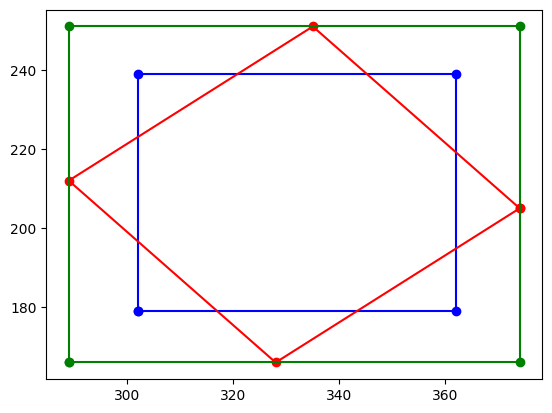

Rotated bounding rectangle: (289,166), (374,251)


In [41]:
import numpy as np
from numpy import sin, cos, sqrt, pi
import math
import matplotlib.pyplot as plt 

center = (332, 209)
width = 30
height = 30
degrees = 130

# topleft
pt1 = [center[0] - width, center[1] - height]
# btmleft
pt2 = [center[0] - width, center[1] + height]
# btmright
pt3 = [center[0] + width, center[1] + height]
# topright
pt4 = [center[0] + width, center[1] - height]

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    
    modified from answer here: https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx), int(qy)

rectangle = [pt1, pt2, pt3, pt4, pt1]

rectangle_rotated = [rotate(center, pt,  math.radians(degrees)) for pt in rectangle]

rectangle = np.array(rectangle)
rectangle_rotated = np.array(rectangle_rotated)

# these are what you need
x_min, y_min = np.min(rectangle_rotated,axis=0)
x_max, y_max = np.max(rectangle_rotated,axis=0)

# create bounding rect points
pt1 = [x_min, y_min]
pt2 = [x_min, y_max]
pt3 = [x_max, y_max]
pt4 = [x_max, y_min ]

rectangle_bounding = [pt1, pt2, pt3, pt4, pt1]

# plot input rectangle in blue, rotated in red, bounding in green
plt.plot(np.array(rectangle)[:,0], np.array(rectangle)[:,1], "bo-")
plt.plot(np.array(rectangle_rotated)[:,0], np.array(rectangle_rotated)[:,1], "ro-")
plt.plot(np.array(rectangle_bounding)[:,0], np.array(rectangle_bounding)[:,1], "go-")
plt.show()

print(f"Rotated bounding rectangle: ({x_min},{y_min}), ({x_max},{y_max})")